In [99]:
import pandas as pd
import numpy as np 
import re
import rpy2.robjects as robjects

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [100]:
abbrev = pd.read_csv("abbrev.csv")
abbrev.head()

,Unnamed: 0,household_size,empl_agriculture,empl_professional,empl_social,empl_services,empl_manufacturing,empl_retail,empl_transp_utilities,prc_fam_poverty,...,cases_april23,cases_april25,cases_may11,ten_plus,order,density,death_prc,cases_prc,prc_incarcerated,uninsured
0,0,2.56,1.079230,11.181199,19.409400,8.323099,22.213539,10.247107,5.654795,9.9,...,50,55,95,44,37,205.559775,0.000000,0.000311,0.005072,1.185668
1,1,3.15,14.810805,7.410151,21.601702,8.941190,7.127118,9.305904,4.424056,15.6,...,35,47,319,29,53,108.941861,0.000007,0.000059,0.003072,9.905791
2,2,3.31,15.989974,10.084580,19.673111,10.873224,6.512608,8.971354,3.888164,10.5,...,154,169,279,51,53,132.778760,0.000014,0.000181,0.002133,3.714698
3,3,2.37,1.339175,16.368947,20.669588,11.533536,3.509718,10.598809,6.790248,5.1,...,36,37,41,44,53,104.091797,0.000010,0.000341,0.001976,1.227732
4,4,2.59,1.066778,9.394248,25.461959,11.484731,4.417867,12.854456,5.007969,9.5,...,28,30,32,38,53,47.687662,0.000022,0.000133,0.001883,0.826483


In [101]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)
abbrev.columns.values

array(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing',
       'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
       'avg_income', 'prc_public_transp', 'population', 'pop_65_plus',
       'aa_and_mixed', 'aa', 'latino', 'immigrant', 'county', 'state',
       'FIPS', 'area', 'prc_obese', 'nh_weighted_health_score',
       'nh_num_beds', 'nh_prc_occupied', 'nh_nurse_hours',
       'nh_total_fines', 'nh_overall_rating', 'incarcerated',
       'domestic_passengers', 'intl_passengers', 'deaths_march24',
       'deaths_april1', 'deaths_april11', 'deaths_april23',
       'deaths_april25', 'deaths', 'cases_march24', 'cases_april1',
       'cases_april11', 'cases_april23', 'cases_april25', 'cases_may11',
       'ten_plus', 'order', 'density', 'death_prc', 'cases_prc',
       'prc_incarcerated', 'uninsured'], dtype=object)

In [102]:
# xgboost was failing to train models with death_prc as label, so made deaths per 100,000 of population, instead

abbrev["deaths_per_100k"] = abbrev.deaths * 100000 / abbrev.population
abbrev["cases_per_100k"] = abbrev.cases_april11 * 100000 / abbrev.population

In [103]:
abbrev.loc[abbrev.deaths_per_100k == 0, "deaths_per_100k"] = 0.00000000000000001
abbrev["log_deaths_per_100k"] = np.log1p(abbrev["deaths_per_100k"])

In [104]:
predictors = ["population", 'household_size', 'empl_agriculture', 'empl_professional',
              'empl_social', 'empl_services', 'empl_manufacturing',
              'empl_retail', 'empl_transp_utilities', 'prc_fam_poverty',
              'avg_income', 'prc_public_transp', 'pop_65_plus', 'aa', 
              'latino', 'immigrant', 'prc_obese', 'nh_weighted_health_score',
              'nh_num_beds', 'nh_prc_occupied', 'nh_nurse_hours',
              'nh_total_fines', 'nh_overall_rating', 'incarcerated',
              'domestic_passengers', 'intl_passengers', 'ten_plus', 'order', 
              'density', 'uninsured', "cases_per_100k"]

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_per_100k')

transform = ["density", "intl_passengers", "domestic_passengers",  
             "incarcerated", "empl_agriculture", "prc_public_transp", 
             "uninsured", "population", "cases_per_100k"]

for field in transform:
    abbrev.loc[abbrev[field] == 0, field] = 0.00000000000000001
    abbrev["log_"+field] = np.log1p(abbrev[field])
    
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
    
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_per_100k')

In [105]:
indp_vars = [predictors_noCaseData, predictors, 
             log_predictors_noCaseData, log_predictors]
labels = ["no case data", "with case data", 
          "with transformed predictors, no case data", 
          "with transformed predictors, with case data"]

In [106]:
# apply standard scaling to predictors

original = abbrev.copy()
all_predictors = set()
for x in indp_vars:
    all_predictors = all_predictors.union(x)
    
all_predictors = list(all_predictors)
scaler = StandardScaler()
scaler.fit(abbrev[all_predictors])
abbrev[all_predictors] = scaler.transform(abbrev[all_predictors])

abbrev[all_predictors].describe()

,density,population,nh_prc_occupied,aa,log_density,ten_plus,log_prc_public_transp,prc_public_transp,log_population,empl_services,...,nh_weighted_health_score,cases_per_100k,log_cases_per_100k,domestic_passengers,log_intl_passengers,nh_total_fines,empl_professional,incarcerated,latino,empl_agriculture
count,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,...,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02,8.270000e+02
mean,1.612643e-17,-3.208504e-17,-3.524153e-16,2.414769e-17,7.691013e-16,1.401539e-16,-4.342892e-17,-4.253953e-17,-9.645367e-16,-3.557547e-17,...,1.060552e-17,1.265278e-17,-2.809833e-16,6.213960e-17,-5.369882e-18,3.894842e-17,4.188508e-17,3.888969e-17,8.434070e-17,9.088525e-17
std,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,...,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00,1.000605e+00
min,-2.498650e-01,-4.640806e-01,-4.763465e+00,-8.668635e-01,-3.258172e+00,-4.934972e+00,-1.043367e+00,-3.915309e-01,-1.270937e+00,-3.473266e+00,...,-1.370365e+00,-5.042981e-01,-3.927347e+00,-4.539130e-01,-5.099840e-01,-6.113514e-01,-2.809658e+00,-6.130193e-01,-8.705924e-01,-7.114566e-01
25%,-2.096455e-01,-4.073826e-01,-5.994815e-01,-6.804759e-01,-6.080646e-01,-4.793710e-01,-6.770501e-01,-3.371632e-01,-7.966149e-01,-6.117986e-01,...,-7.126995e-01,-3.670092e-01,-6.071107e-01,-4.539130e-01,-5.099840e-01,-5.351267e-01,-6.728445e-01,-4.260728e-01,-5.872008e-01,-5.121651e-01
50%,-1.708331e-01,-2.988431e-01,1.292381e-01,-3.503566e-01,-7.606530e-02,6.399497e-02,-3.024958e-01,-2.646729e-01,-2.306876e-01,-1.329819e-01,...,-1.842705e-01,-2.759733e-01,-1.227192e-01,-4.217655e-01,-5.099840e-01,-3.063778e-01,-1.435173e-01,-2.728744e-01,-3.665880e-01,-3.259710e-01
75%,-8.304943e-02,6.448881e-03,7.246773e-01,2.821226e-01,5.206932e-01,6.073609e-01,3.942034e-01,-6.532454e-02,6.043379e-01,4.316509e-01,...,4.072415e-01,-4.187061e-02,5.574019e-01,-2.177694e-01,-5.099840e-01,1.291754e-01,5.074356e-01,4.728821e-02,1.521089e-01,1.320938e-01
max,2.082053e+01,1.655084e+01,3.647616e+00,5.025472e+00,4.433106e+00,2.672152e+00,4.712229e+00,1.060887e+01,4.360334e+00,8.014222e+00,...,1.023941e+01,1.044055e+01,3.642800e+00,4.477269e+00,2.454217e+00,1.248009e+01,5.563573e+00,1.481073e+01,6.120548e+00,8.773816e+00


# XGBoost

In [107]:
dtrain = xgb.DMatrix(abbrev[indp_vars[0]], label=abbrev["deaths_per_100k"])
dtrain2 = xgb.DMatrix(abbrev[indp_vars[0]], label=abbrev["log_deaths_per_100k"])
dtrain3 = xgb.DMatrix(abbrev[indp_vars[1]], label=abbrev["deaths_per_100k"])
dtrain4 = xgb.DMatrix(abbrev[indp_vars[1]], label=abbrev["log_deaths_per_100k"])

dtrain5 = xgb.DMatrix(abbrev[indp_vars[2]], label=abbrev["deaths_per_100k"])
dtrain6 = xgb.DMatrix(abbrev[indp_vars[2]], label=abbrev["log_deaths_per_100k"])
dtrain7 = xgb.DMatrix(abbrev[indp_vars[3]], label=abbrev["deaths_per_100k"])
dtrain8 = xgb.DMatrix(abbrev[indp_vars[3]], label=abbrev["log_deaths_per_100k"])

### no case data, raw death rate


In [108]:
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py
# using xgboost's built-in cross validation, will manually implement a grid search myself

md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'silent':1, 'lambda':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain, num_round, nfold=10, seed=1001, 
                   callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                              xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[3]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82

In [109]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 17.8629094


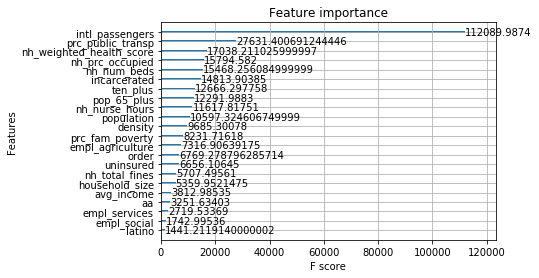

In [110]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'silent':1, 'lambda':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain)
xgb.plot_importance(xgb_model, importance_type="gain")

# effectively doesn't create a model

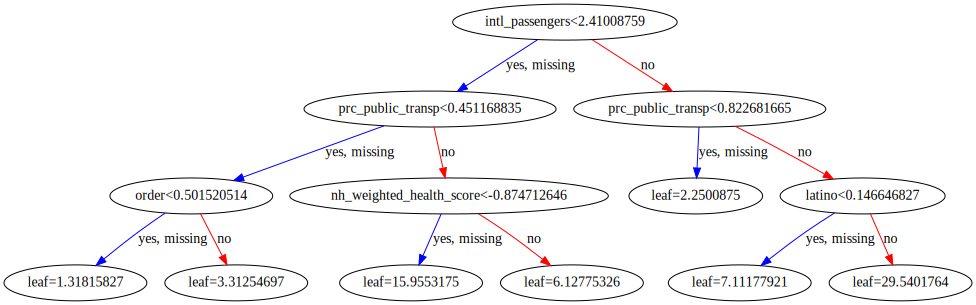

In [111]:
xgb.to_graphviz(xgb_model)

### no case data, with log-transformed response

In [112]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain2, num_round, nfold=10, seed=1001, 
                   callbacks=[#xgb.callback.print_evaluation(show_stdv=True),
                              xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.0

In [113]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 0.8817672000000002


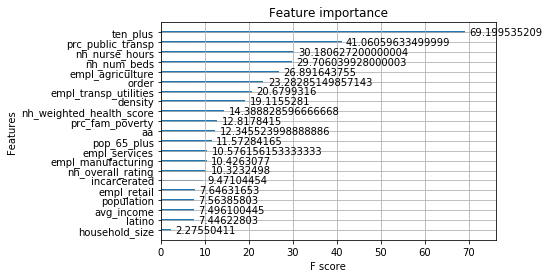

In [114]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain2)
xgb.plot_importance(xgb_model, importance_type="gain")

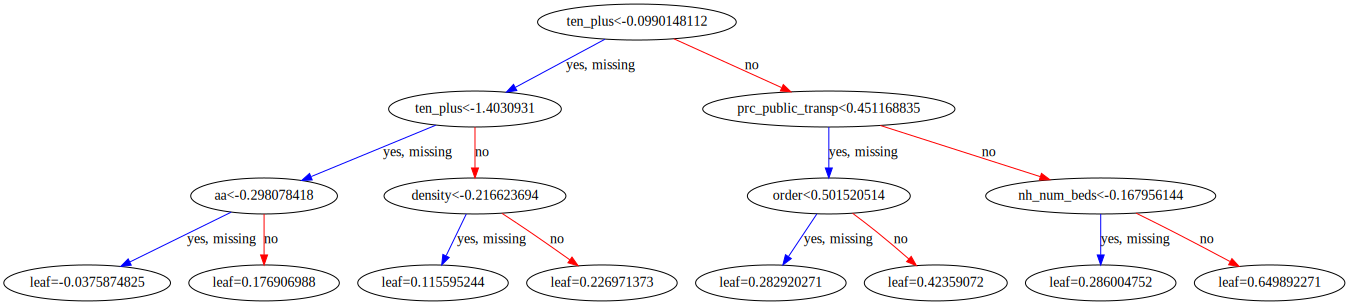

In [115]:
xgb.to_graphviz(xgb_model)

### with case data, raw death rate

In [116]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain3, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[4]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[3]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[2]	train-rmse:30.82

In [117]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 10.3136042


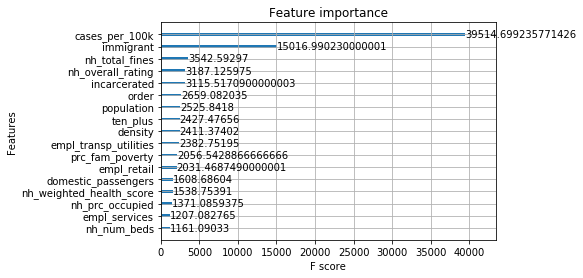

In [118]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain3)
xgb.plot_importance(xgb_model, importance_type="gain")

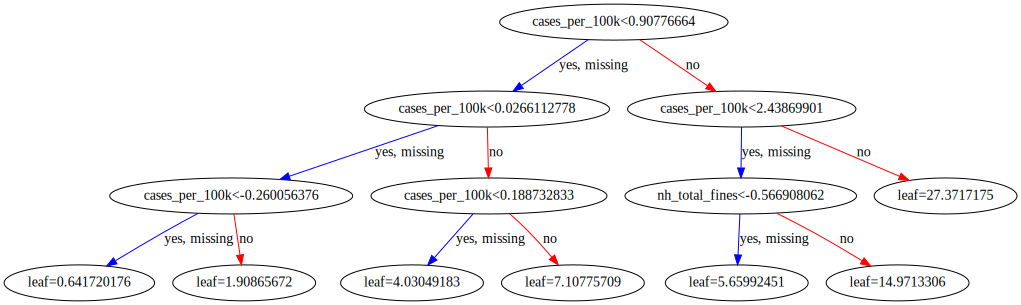

In [119]:
xgb.to_graphviz(xgb_model)

### with case data, log-transformed death rate

In [120]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain4, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.0

In [121]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 0.6877279000000001


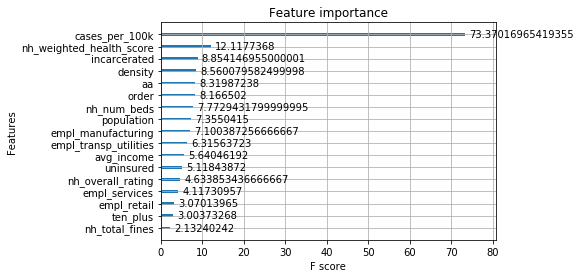

In [123]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain4)
xgb.plot_importance(xgb_model, importance_type="gain")

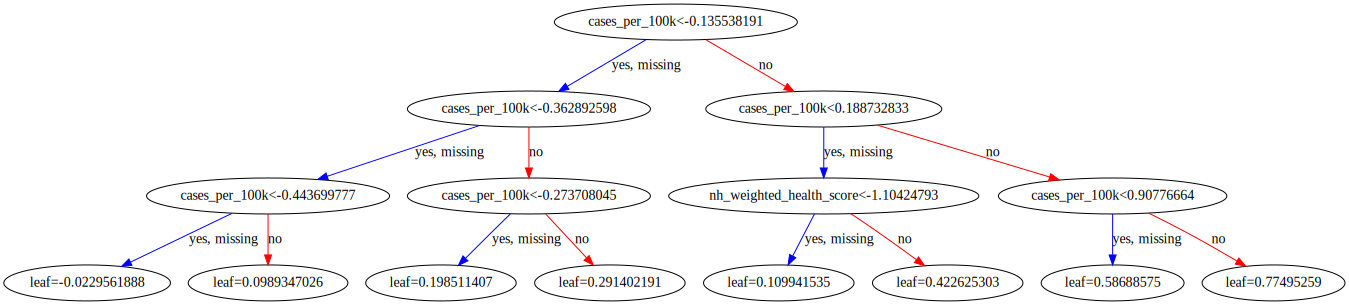

In [124]:
xgb.to_graphviz(xgb_model)

# cases per 100k clearly very important, but what influences that? (look at separate models)

### no case data, raw death rate, selected log-transformed predictors

In [128]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain5, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:30.82

In [129]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 17.4717869


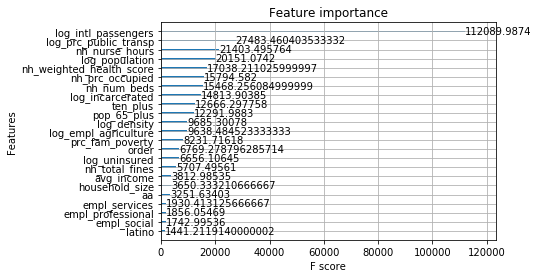

In [130]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain5)
xgb.plot_importance(xgb_model, importance_type="gain")

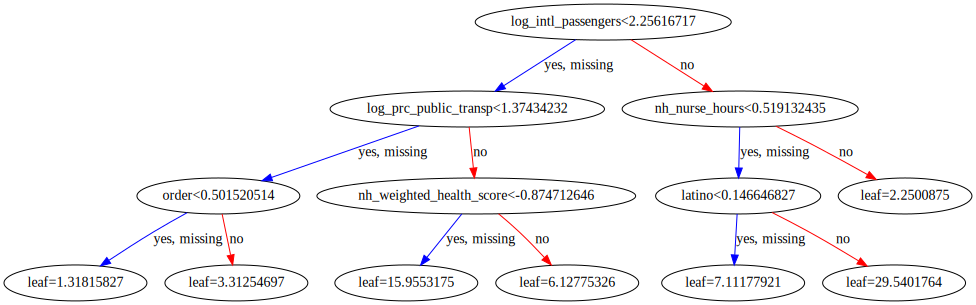

In [131]:
xgb.to_graphviz(xgb_model)

### no case data, log-transformed target, selected log-transformed predictors

In [132]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain6, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.0

In [133]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 0.8818777000000001


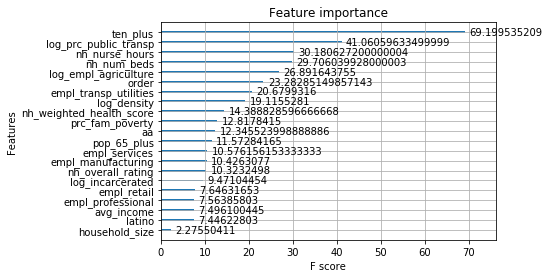

In [134]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain6)
xgb.plot_importance(xgb_model, importance_type="gain")

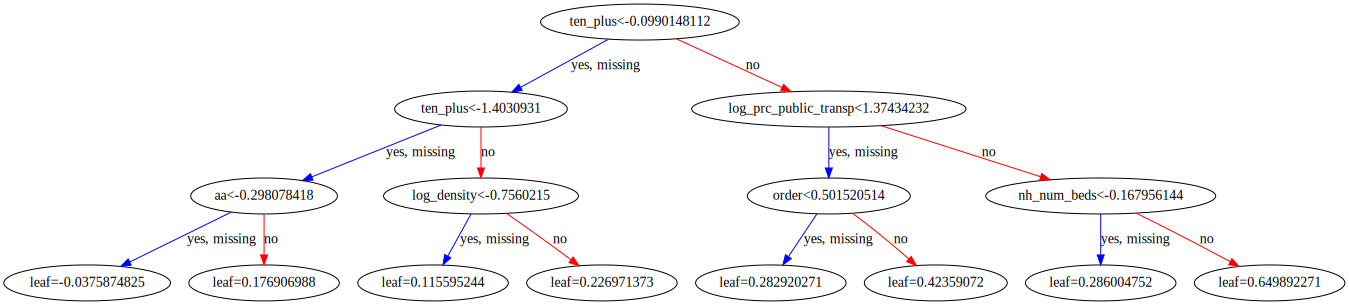

In [135]:
xgb.to_graphviz(xgb_model)

### with case data, raw death rate, selected log-transformed predictors

In [136]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain7, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[5]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:30.82386+0.64137	test-rmse:30.16135+6.28827

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[1]	train-rmse:30.82

In [137]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 10.2620404


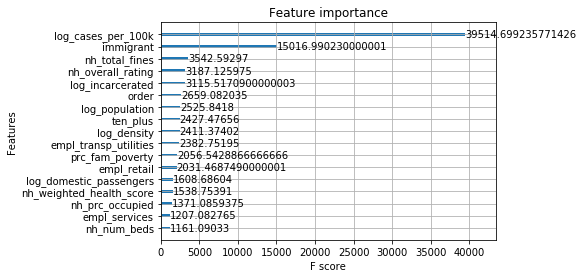

In [138]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain7)
xgb.plot_importance(xgb_model, importance_type="gain")

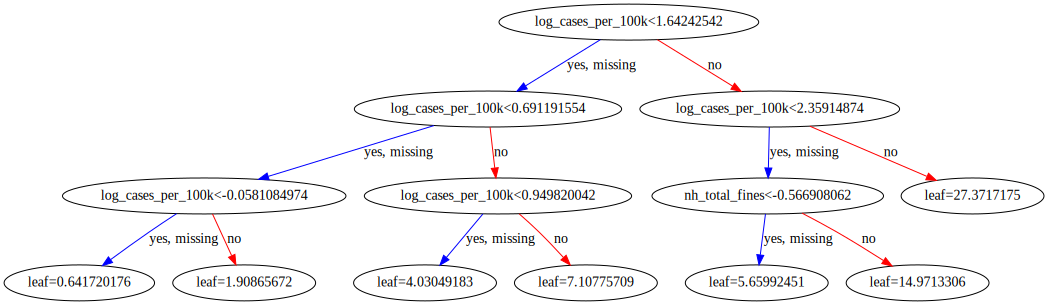

In [139]:
xgb.to_graphviz(xgb_model)

### with case data, log-transformed target, selected log-transformed predictors

In [140]:
md = [3,4,5,6,7,8,9]
eta = [0, 0.2, 0.4, 0.6, 0.8, 1]
gamma  = [0, 0.5, 1, 1.5]

best_md = 0
best_eta = 0
beta_gamma = 0
best_test_rmse = np.Inf


for x in md:
    for y in eta:
        for z in gamma:
            print("max-depth: {}, eta: {}, gamma: {}".format(x, y, z))
            param = {'max_depth':x, 'eta':y, 'gamma':z, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
            num_round = 100
            cv = xgb.cv(param, dtrain8, num_round, nfold=10, seed=1001, 
                   callbacks=[xgb.callback.early_stop(3)])
            if cv.iloc[-1,]["test-rmse-mean"] < best_test_rmse:
                best_test_rmse = cv.iloc[-1,]["test-rmse-mean"]
                best_md = x
                best_eta = y
                best_gamma = z
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

max-depth: 3, eta: 0, gamma: 0
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 0.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.02105	test-rmse:1.89568+0.19565

max-depth: 3, eta: 0, gamma: 1.5
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 3 rounds.
Stopping. Best iteration:
[0]	train-rmse:1.90621+0.0

In [141]:
print("best max depth = {}, eta = {}, gamma = {}, with mean RMSE = {}".format(best_md, best_eta, best_gamma, best_test_rmse))

best max depth = 3, eta = 0.2, gamma = 1.5, with mean RMSE = 0.6877279000000001


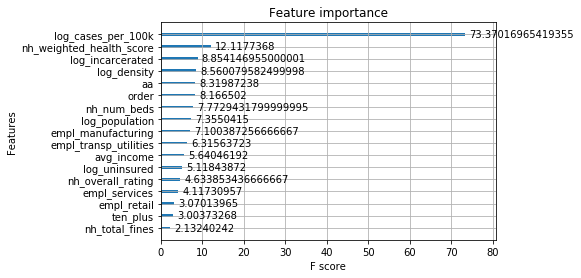

In [142]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain8)
xgb.plot_importance(xgb_model, importance_type="gain")

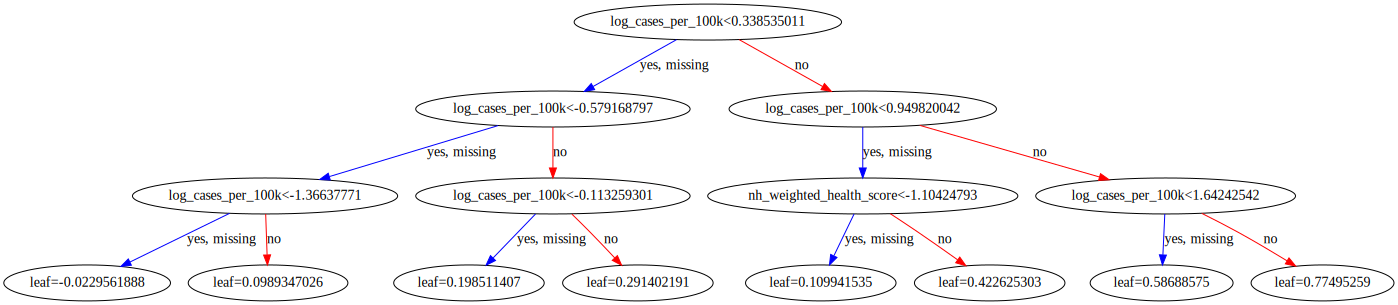

In [143]:
xgb.to_graphviz(xgb_model)

### Final XGBoost Model

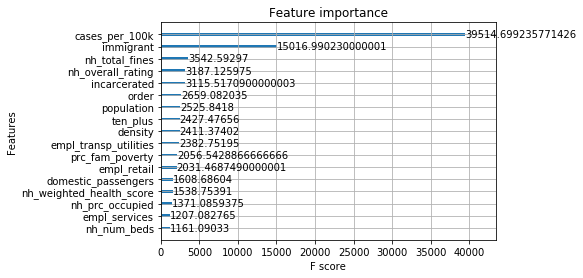

In [144]:
param = {'max_depth':3, 'eta':0.2, 'gamma':1.5, 'lambda':1, 'silent':1, 'objective':'reg:squarederror'}
param['random_seed'] = 1001
xgb_model = xgb.train(param, dtrain3)
xgb.plot_importance(xgb_model, importance_type="gain")

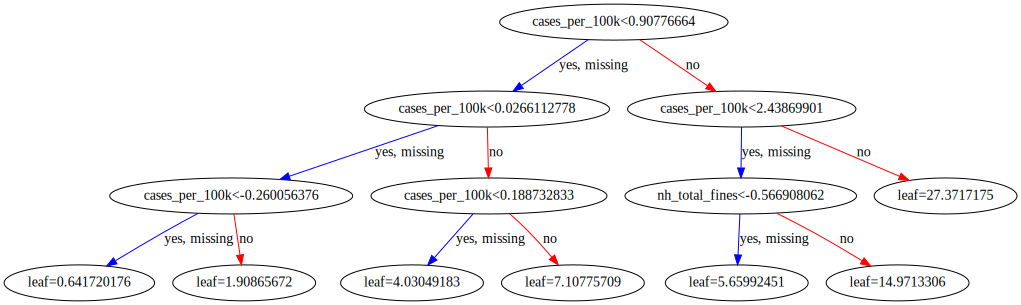

In [145]:
xgb.to_graphviz(xgb_model)
# critical points: the number of cases per 100k a month ago, and also the average amount of fines on nursing homes in the county

In [150]:
abbrev["xgb_pred"] = xgb_model.predict(dtrain3)
np.sqrt(mean_squared_error(abbrev.deaths_per_100k, abbrev.xgb_pred))

9.033302049968013

In [160]:
abbrev.loc[abbrev["state"] == "CA", ["county", "xgb_pred", "deaths_per_100k"]]

# where counties had 0 deaths, model really overpredicts; much better everywhere else

,county,xgb_pred,deaths_per_100k
1,Kings County,2.538772,6.606503e-01
2,Monterey County,3.056018,1.377429e+00
3,Nevada County,4.233712,1.003049e+00
4,Shasta County,3.056018,2.221729e+00
5,Yuba County,2.538772,1.281378e+00
112,Riverside County,6.896080,8.854403e+00
113,Santa Clara County,7.283271,6.657824e+00
114,Santa Cruz County,3.475354,7.292483e-01
115,Stanislaus County,3.475354,3.819467e+00
116,Sutter County,4.233712,2.065966e+00


In [171]:
pred = xgb_model.predict(dtrain)

In [177]:
pred.mean()

15.847876

In [178]:
pred.min()

0.05907291

In [179]:
pred.max()

67.14487

In [172]:
delta = abbrev["deaths"] - pred

In [175]:
delta.describe()

count     827.000000
mean       34.206537
std       213.677106
min       -67.144866
25%        -0.843842
50%         0.000211
75%         1.903937
max      3236.855133
Name: deaths, dtype: float64